<a id='top'></a><a name='top'></a>
# Chapter 12: Building a Knowledge Graph

**Blueprints for Text Analysis Using Python**

* [Introduction](#introduction)
* [12.0 Imports and Setup](#12.0)
* [12.1 Knowledge Graphs](#12.1)
     - [12.1.1 Information Extraction](#12.1.1)
     - [12.1.2 Blueprint to Query Wikidata for Aliases (not in book)](#12.1.2)
* [12.2 Introducing the Dataset](#12.2)
    - [12.2.1 Data Preparation of NLTK Reuters Corpus (not in book)](#12.2.1)
* [12.3 Named-Entity Recognition](#12.3)
    - [12.3.1 Blueprint: Using Rule-Based Named-Entity Recognition](#12.3.1)
    - [12.3.2 Blueprint: Normalizing Named Entities](#12.3.2)
    - [12.3.3 Merging Entity Tokens](#12.3.3)
    - [12.3.4 Testing the NER Pipeline on Sample Data (not in book)](#12.3.4)
* [12.4 Coreference Resolution](#12.4)
    - [12.4.1 Blueprint: Using spaCy's Token Extensions](#12.4.1)
    - [12.4.2 Blueprint: Performing Alias Resolution](#12.4.2)
    - [12.4.3 Blueprint: Resolving Name Variations](#12.4.3)
    - [12.4.4 Testing Name Coreference Resolution Sample Data (not in book)](#12.4.4)
    - [12.4.5 Blueprint: Performing Anaphora Resolution with NeuralCoref](#12.4.5)
    - [12.4.6 Name Normalization](#12.4.6)
    - [12.4.7 Entity Linking](#12.4.7)
    - [12.4.8 Testing Coreference Resolution (not in book)](#12.4.8)
* [12.5 Blueprint: Creating a Co-Occurrence Graph](#12.5)
    - [12.5.1 Extracting Co-Occurrences from a Document](#12.5.1)
    - [12.5.2 Visualizing the Graph with Gephi](#12.5.2)
* [12.6 Relation Extraction](#12.6)
    - [12.6.1 Blueprint: Extracting Relations Using Phrase Matching](#12.6.1)
    - [12.6.2 Blueprint: Extracting Relations Using Dependency Trees](#12.6.2)
* [12.7 Creating the Knowledge Graph](#12.7)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Datasets
* NLTK Reuters corpus: [script](#nltk_reuters), [source](https://www.nltk.org/book/ch02.html)
    - The Reuters Corpus contains 10,788 news documents totaling 1.3 million words. The documents have been classified into 90 topics, and grouped into two sets, called "training" and "test"; thus, the text with fileid 'test/14826' is a document drawn from the test set. This split is for training and testing algorithms that automatically detect the topic of a document.

### Explore

* Advanced language features of spaCy.
* Pretrained neural models in combination with custom rules for named-entity recognition, coreference resolution, and relation extraction. 
* Necessary steps to perform entity linking

### Misc

* A coreference module is now built-in to Spacy 3, which means we will not use HugginfFace's `neuralcoref` package. 
    - https://github.com/huggingface/neuralcoref/issues/295 

---
<a name='12.0'></a><a id='12.0'></a>
# 12.0 Imports and Setup
<a href="#top">[back to top]</a>

In [134]:
# # Start with clean project
# !rm -f *.gexf 
# !rm -f *.py 
# !rm -f *.txt

In [135]:
req_file = "requirements_12.txt"

In [136]:
%%writefile {req_file}
isort
scikit-learn-intelex
scikit-learn
spacy
SPARQLWrapper
textacy
tqdm
transformers
watermark

Overwriting requirements_12.txt


In [137]:
import sys

IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [138]:
%%writefile imports.py
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import locale
import math
import pprint
import re
import sys
import textwrap
import warnings
from itertools import combinations
from math import ceil

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import pandas as pd
import seaborn as sns
import spacy
from networkx import MultiDiGraph
from nltk.corpus import reuters
from spacy import Language, displacy
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler, merge_entities
from spacy.tokens import Span, Token
from SPARQLWrapper import JSON, SPARQLWrapper
from tqdm import notebook, tqdm, trange
from watermark import watermark

Overwriting imports.py


In [139]:
!isort imports.py
!cat imports.py

# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import locale
import math
import pprint
import re
import sys
import textwrap
import warnings
from itertools import combinations
from math import ceil

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import pandas as pd
import seaborn as sns
import spacy
from networkx import MultiDiGraph
from nltk.corpus import reuters
from spacy import Language, displacy
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler, merge_entities
from spacy.tokens import Span, Token
from SPARQLWrapper import JSON, SPARQLWrapper
from tqdm import notebook, tqdm, trange
from watermark import watermark


In [140]:
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import locale
import math
import pprint
import re
import sys
import textwrap
import warnings
from itertools import combinations
from math import ceil

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import pandas as pd
import seaborn as sns
import spacy
from networkx import MultiDiGraph
from nltk.corpus import reuters
from spacy import Language, displacy
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler, merge_entities
from spacy.tokens import Span, Token
from SPARQLWrapper import JSON, SPARQLWrapper
from tqdm import notebook, tqdm, trange
from watermark import watermark

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [141]:
# Make sure we are using spaCy v3.0
assert spacy.__version__[0] >= '3'

In [142]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

print(watermark(iversions=True, globals_=globals(),python=True, machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

re            : 2.2.1
nltk          : 3.8
pandas        : 1.5.3
spacy         : 3.5.1
en_core_web_lg: 3.5.0
tqdm          : 4.64.1
seaborn       : 0.12.1
networkx      : 3.0
sys           : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
matplotlib    : 3.6.2



In [143]:
spacy.util.get_installed_models()

['en_core_web_lg', 'en_core_web_sm', 'en_core_web_md']

In [144]:
def install_spacy_packages(spacy_model_name):
    if not spacy.util.is_package(spacy_model_name):
        spacy.cli.download(spacy_model_name)
    else:
        print(f"{spacy_model_name} is installed.")
    
spacy_model_name = 'en_core_web_sm'
install_spacy_packages(spacy_model_name)
nlp = spacy.load(spacy_model_name)

en_core_web_sm is installed.


---
We adjusted the this notebook to run with spaCy 3.0.

Note: spaCy 3.0 includes transformer models, which are more accurate than  conventional models. If you go for accuracy in named entity recognition, you should prefer the transformer models. 

See https://spacy.io/universe/project/spacy-transformers

<hr/>

**Changes to `nlp.add_pipe`**: https://spacy.io/api/language#add_pipe  
"As of v3.0, the Language.add_pipe method doesn’t take callables anymore and instead expects the name of a component factory registered using @Language.component or @Language.factory. It now takes care of creating the component, adds it to the pipeline and returns it."

**Changes to `matcher.add`**: https://spacy.io/api/matcher#add  
"As of spaCy v3.0, Matcher.add takes a list of patterns as the second argument (instead of a variable number of arguments). The on_match callback becomes an optional keyword argument."

**NeuralCoref not yet supported in spaCy 3**

But planned: https://github.com/huggingface/neuralcoref/issues/295

Currently, we cannot import NeuralCoref, so the functions for anaphora resolution are replaced by dummies in this notebook.

In [145]:
# Blueprints application functions
def display_ner(doc, include_punct=False):
    """Generate data frame for visualization of spaCy doc with custom attributes."""

    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i, 
                   'text': t.text, 'lemma': t.lemma_, 
                   'pos': t.pos_, 'dep': t.dep_, 'ent_type': t.ent_type_,
                   'ent_iob_': t.ent_iob_}
            
            if doc.has_extension('has_coref'):
                if doc._.coref_clusters is not None and \
                   t.has_extension('in_coref') and t._.in_coref: # neuralcoref attributes
                    row['in_coref'] = t._.in_coref
                    row['main_coref'] = t._.coref_clusters[0].main.text
                else:
                    row['in_coref'] = None
                    row['main_coref'] = None
            if t.has_extension('ref_n'): # referent attribute
                row['ref_n'] = t._.ref_n
                row['ref_t'] = t._.ref_t
            if t.has_extension('ref_ent'): # ref_n/ref_t
                row['ref_ent'] = t._.ref_ent
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    
    return df


def reset_pipeline(nlp, pipes):
    # remove all custom pipes
    custom_pipes = [pipe for (pipe, _) in nlp.pipeline
                    if pipe not in ['tagger', 'parser', 'ner',
                                    'tok2vec', 'attribute_ruler', 'lemmatizer']]
    for pipe in custom_pipes:
        _ = nlp.remove_pipe(pipe)
    # re-add specified pipes
    for pipe in pipes:
        if 'neuralcoref' == pipe or 'neuralcoref' in str(pipe.__class__):
            nlp.add_pipe(pipe, name='neural_coref')
        else:
            nlp.add_pipe(pipe)

    print(f"Model: {nlp.meta['name']}, Language: {nlp.meta['lang']}")
    print(*nlp.pipeline, sep='\n')


def print_dep_tree(doc, skip_punct=True):
    """Utility function to pretty print the dependency tree."""
    
    def print_recursive(root, indent, skip_punct):
        if not root.dep_ == 'punct' or not skip_punct:
            print(" "*indent + f"{root} [{root.pos_}, {root.dep_}]")
        for left in root.lefts:
            print_recursive(left, indent=indent+4, skip_punct=skip_punct)
        for right in root.rights:
            print_recursive(right, indent=indent+4, skip_punct=skip_punct)

    for sent in doc.sents: # iterate over all sentences in a doc
        print_recursive(sent.root, indent=0, skip_punct=skip_punct) 


# acronyms created after cooccurrence analysis
_acronyms = {
    'AMC': 'American Motors Corp',
    'AMI': 'American Medical International Inc',
    'ARCO': 'Atlantic Richfield Co',
    'BIL': 'Brierley Investments Ltd',
    'BP': 'British Petroleum Co Plc',
    'BPI': 'Banco Portugues de Investmento Sarl',
    'CGCT': 'Cie Generale de Constructions',
    'DAF': 'Delhi Australia Fund',
    'EC': 'European Community',
    'ETL': 'Equiticorp Tasman Ltd',
    'FCC': 'Federal Communications Commission',
    'FDA': 'Food and Drug Administration',
    'FHLBB': 'Federal Home Loan Bank Board',
    'FIRB': 'Foreign Investment Review Board',
    'FTC': 'Federal Trade Commission',
    'ICC': 'Interstate Commerce Commission',
    'IDC': 'International Digital Communications Planning Inc',
    'ITJ': 'International Telecom Japan Inc',
    'KDD': 'Kokusai Denshin Denwa Co Ltd',
    'PCGG': 'Presidential Commission on Good Government',
    'PSA': 'Pacific Southwest Airlines',
    'SMC': 'San Miguel Corp',
    'TWA': 'Trans World Airlines Inc',
    'UCPB': 'United Coconut Planters Bank'
}

# add acronyms (all acronyms are organizations)
alias_lookup = {acro: (text, 'ORG') for (acro, text) in _acronyms.items()}

alias_lookup['SEC'] = ('Securities and Exchange Commission', 'GOV')
    
alias_list = {('U.S. Department of Justice', 'GOV'): 
                ['U.S. Department of Justice',
                 'Department of Justice', 
                 'U.S. Justice Department', 
                 'Justice Department'],
              ('U.S. Department of Transportation', 'GOV'): 
                ['U.S. Department of Transportation',
                 'U.S. Transportation Department',
                 'Department of Transportation',
                 'Transportation Department',
                 'DOT'],
              ('USAir Group Inc', 'ORG'):
                ['USAir Group Inc', 'USAir Group Inc.',
                 'US Air Corp', 'US Air Corp.',
                 'USAir Group', 'USAir Group Inc', 'USAir Group Inc.',
                 'US Air', 'USAir', 'U.S. Air', 'USAIR Group',
                 'U.S. Air Group Inc.'],
              ('Trans World Airlines Inc', 'ORG'):
                ['Transworld Airlines', 'Transworld Airlines Inc', 'Trans World Airlines'],
}         

# invert alias_list; overwrites entries in acronyms like DOT
alias_lookup.update({alias: ent for (ent, aliases) in alias_list.items() 
                                for alias in aliases})


---
<a name='12.1'></a><a id='12.1'></a>
# 12.1 Knowledge Graphs
<a href="#top">[back to top]</a>

<a name='12.1.1'></a><a id='12.1.1'></a>
## 12.1.1 Information Extraction
<a href="#top">[back to top]</a>

<a name='12.1.2'></a><a id='12.1.2'></a>
## 12.1.2 Blueprint to Query Wikidata for Aliases (not in book)
<a href="#top">[back to top]</a>

Below you find an example of what you can do with public ontologies like Wikidata. Here, we defined a SPARQL query to retrieve the names, aliases and URLs of all entities of type "United States federal executive department" (https://www.wikidata.org/wiki/Q910252).

In [146]:
endpoint_url = "https://query.wikidata.org/sparql"

query = """
SELECT ?org ?orgLabel ?aliases ?urlLabel ?country ?countryLabel WITH {
  SELECT ?org (group_concat(distinct ?alias;separator=",") as ?aliases)
  WHERE {
    ?org wdt:P31 wd:Q910252. # org is(P31) US department (Q910252)
    ?org skos:altLabel ?alias. filter(lang(?alias)="en")
  } GROUP BY ?org } AS %i
  WHERE {
  include %i
  ?org wdt:P856 ?url; # has official website (P856)
       wdt:P17 ?country. # has country (P17)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?orgLabel
"""

def sparql_df(endpoint_url, query):
    user_agent = "Wikidata-Service Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    columns = results['head']['vars']
    rows = []
    for result in results["results"]["bindings"]:
        row = {}
        for col in result:
            row[col] = result[col]['value']
        rows.append(row)

    return pd.DataFrame.from_records(rows, columns=columns)

wd_df = sparql_df(endpoint_url, query)

# rename columns
wd_df.columns = ['org_id', 'org', 'aliases', 'url', 'country_id', 'country']

wd_df['org_id'] = wd_df['org_id'].str.replace('http://www.wikidata.org/entity/', '')
wd_df['country_id'] = wd_df['country_id'].str.replace('http://www.wikidata.org/entity/', '')
wd_df['aliases'] = wd_df['aliases'].str.split(',')

wd_df.head(10)

,org_id,org,aliases,url,country_id,country
0,Q501542,United States Department of Agriculture,"[Department of Agriculture, USDA, U.S. Department of Agriculture, U. S. Department of Agriculture, Agriculture Department]",https://www.usda.gov/,Q30,United States of America
1,Q503577,United States Department of Commerce,"[DOC, Commerce, Department of Commerce, Commerce Department, U.S Department of Commerce, US Department of Commerce]",https://www.commerce.gov/,Q30,United States of America
2,Q11209,United States Department of Defense,"[Pentagon, DOD, DoD, Department of Defense, Defense Department, defense.gov, U.S. Department of Defense, US Department of Defense, US DOD, USDOD]",https://www.defense.gov/,Q30,United States of America
3,Q861556,United States Department of Education,"[ED, Department of Education, USDOE, Dept. of Ed., DoED, U. S. Department of Education, U.S. Department of Education, US Department of Education]",https://www.ed.gov/,Q30,United States of America
4,Q217810,United States Department of Energy,"[Department of Energy, DOE, energy.gov, U.S. Department of Energy, US Department of Energy, USDOE]",https://www.energy.gov/,Q30,United States of America
5,Q942326,United States Department of Health and Human Services,"[HHS, Department of Health and Human Services, DHHS, U.S. Department of Health and Human Services, US Department of Health and Human Services]",https://www.hhs.gov/,Q30,United States of America
6,Q11231,United States Department of Homeland Security,"[DHS, Department of Homeland Security, Homeland Security, Homeland Security Department, U.S. Department of Homeland Security, US Department of Homeland Security, USDHS]",https://www.dhs.gov/,Q30,United States of America
7,Q811595,United States Department of Housing and Urban Development,"[HUD, Department of Housing and Urban Development, Housing and Urban Development Department, U.S. Department of Housing and Urban Development]",https://www.hud.gov/,Q30,United States of America
8,Q1553390,United States Department of Justice,"[Department of Justice, DOJ, Justice Department, justice.gov, U.S. Department of Justice, U.S. DOJ, U.S. Justice Department, United States Justice Department, US Justice Department, USDOJ]",https://www.justice.gov/,Q30,United States of America
9,Q628807,United States Department of Labor,"[DOL, Department of Labor, U.S. Department of Labor, US Department of Labor]",https://www.dol.gov/,Q30,United States of America


---
<a name='12.2'></a><a id='12.2'></a>
# 12.2 Introducing the Dataset
<a href="#top">[back to top]</a>

<a id='nltk_reuters'></a><a name='nltk_reuters'></a>
### Dataset: NLTK Reuters
<a href="#top">[back to top]</a>

In [ ]:
nltk.download('reuters')

[nltk_data] Downloading package reuters to /Users/gb/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [148]:
print(len(reuters.fileids()))
HR()
print(reuters.fileids()[:10])

10788
----------------------------------------
['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833', 'test/14839', 'test/14840', 'test/14841', 'test/14842', 'test/14843']


In [149]:
print(len(reuters.categories()))
HR()
print(reuters.categories())

90
----------------------------------------
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


In [150]:
# Specify the words or sentences we want in terms of files or categories. 
# The first handful of words in each of these texts are the titles, which by convention are stored as upper case.
reuters.words('training/9865')[:14]

['FRENCH',
 'FREE',
 'MARKET',
 'CEREAL',
 'EXPORT',
 'BIDS',
 'DETAILED',
 'French',
 'operators',
 'have',
 'requested',
 'licences',
 'to',
 'export']

In [151]:
reuters.words(categories='barley')

['FRENCH', 'FREE', 'MARKET', 'CEREAL', 'EXPORT', ...]

In [152]:
reuters.words(categories=['barley', 'corn'])

['THAI', 'TRADE', 'DEFICIT', 'WIDENS', 'IN', 'FIRST', ...]

<a name='12.2.1'></a><a id='12.2.1'></a>
## 12.2.1 Data Preparation of NLTK Reuters Corpus (not in book)
<a href="#top">[back to top]</a>

This section contains the steps how to create the data frame for some of the examples.

In [153]:
# List of documents

documents = reuters.fileids()

print(str(len(documents)) + " documents")
print(str(len(reuters.categories())) + " categories:")
print(reuters.categories()[:10] + ['...'])

print(reuters.readme()[:200])

10788 documents
90 categories:
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', '...']

      The Reuters-21578 benchmark corpus, ApteMod version

This is a publically available version of the well-known Reuters-21578
"ApteMod" corpus for text categorization.  It has been used in
public


---
Each article is stored as a separated file. The data files are identified by a file ID of the form "train/1234" or "test/5678". We first create a data frame with the `fileid` column and then load the raw text for each ID into a second column. Finally, as we don't care whether it's train or test, we just the number from the file ID and use it as the index of our data frame.

In [154]:
# create fileid column 
df = pd.DataFrame(reuters.fileids("acq"), columns=['fileid'])

df.head()

,fileid
0,test/14843
1,test/14852
2,test/14865
3,test/14888
4,test/14900


In [155]:
# load raw texts
df['raw'] = df['fileid'].progress_map(lambda f: reuters.raw(f))

df['raw'].head()

progress-bar: 100%|█████████████████████████| 2369/2369 [00:01<00:00, 1409.98it/s]


0    SUMITOMO BANK AIMS AT QUICK RECOVERY FROM MERGER\n  Sumitomo Bank Ltd &lt;SUMI.T> is certain to\n  lose its status as Japan's most profitable bank as a result of\n  its merger with the Heiwa Sogo ...
1    BOND CORP STILL CONSIDERING ATLAS MINING BAIL-OUT\n  Bond Corp Holdings Ltd &lt;BONA.S> and Atlas\n  Consolidated Mining and Development Corp &lt;ATLC.MN> are still\n  holding talks on a bail-out ...
2    CRA SOLD FORREST GOLD FOR 76 MLN DLRS - WHIM CREEK\n  &lt;Whim Creek Consolidated NL> said the\n  consortium it is leading will pay 76.55 mln dlrs for the\n  acquisition of CRA Ltd's &lt;CRAA.S> &...
3    ANHEUSER-BUSCH JOINS BID FOR SAN MIGUEL\n  Anheuser-Busch Companies Inc &lt;BUD.N> has\n  joined several other foreign bidders for sequestered shares of\n  the Philippines' largest food and bevera...
4    MONIER SAYS BRITAIN'S REDLAND MAY BID FOR IT\n  Diversified building materials group\n  Monier Ltd &lt;MNRA.S> said talks are taking place which may lead\n  to Britain's Redla

In [156]:
df.head()

,fileid,raw
0,test/14843,SUMITOMO BANK AIMS AT QUICK RECOVERY FROM MERGER\n Sumitomo Bank Ltd &lt;SUMI.T> is certain to\n lose its status as Japan's most profitable bank as a result of\n its merger with the Heiwa Sogo ...
1,test/14852,BOND CORP STILL CONSIDERING ATLAS MINING BAIL-OUT\n Bond Corp Holdings Ltd &lt;BONA.S> and Atlas\n Consolidated Mining and Development Corp &lt;ATLC.MN> are still\n holding talks on a bail-out ...
2,test/14865,CRA SOLD FORREST GOLD FOR 76 MLN DLRS - WHIM CREEK\n &lt;Whim Creek Consolidated NL> said the\n consortium it is leading will pay 76.55 mln dlrs for the\n acquisition of CRA Ltd's &lt;CRAA.S> &...
3,test/14888,ANHEUSER-BUSCH JOINS BID FOR SAN MIGUEL\n Anheuser-Busch Companies Inc &lt;BUD.N> has\n joined several other foreign bidders for sequestered shares of\n the Philippines' largest food and bevera...
4,test/14900,MONIER SAYS BRITAIN'S REDLAND MAY BID FOR IT\n Diversified building materials group\n Monier Ltd &lt;MNRA.S> said talks are taking place which may lead\n to Britain's Redland Plc &lt;RDLD.L> ma...


In [157]:
# set index to numeric id
df.index = df['fileid'].progress_map(lambda f: int(f.split('/')[1]))
df.index.name = None
df = df.drop(columns=['fileid']).sort_index()

df.sample(3, random_state=12)

progress-bar: 100%|███████████████████████| 2369/2369 [00:00<00:00, 240477.90it/s]


,raw
12441,GUINNESS TO SELL RETAIL INTERESTS\n Guinness Plc &lt;GUIN.L> said that as part\n of a new strategy for the company it will be selling its retail\n interests to concentrate resources on developi...
3061,FIRST BOSTON AFFILIATE TO ACQUIRE ALLEGHENY INT'L FOR 24.60 DLRS/SHR\n\n FIRST BOSTON AFFILIATE TO ACQUIRE ALLEGHENY INT'L FOR 24.60 DLRS/SHR\n \n\n
17810,"ATCOR&lt;ATCO.O> SEEKS BUYERS FOR CONSUMER BUSINESS\n Atcor Inc said that Roth-American Inc,\n which had signed a letter of intent on May 1 to acquire its\n Turco and Charmglow operations of it..."


As we see from the example, we will still need some data cleaning before we can expect to get reasonably good results during named entity recognition. First, we separate headlines from the actual news text by splitting at the first newline.

In [158]:
df[['headline', 'raw_text']] = df.progress_apply(
    lambda row: row['raw'].split('\n', 1), 
    axis='columns', 
    result_type='expand'
)

progress-bar: 100%|████████████████████████| 2369/2369 [00:00<00:00, 21959.80it/s]


In [159]:
df.head()

,raw,headline,raw_text
10,"COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES SALE\n Computer Terminal Systems Inc said\n it has completed the sale of 200,000 shares of its common\n stock, and warrants to acquire an additiona...",COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES SALE,"Computer Terminal Systems Inc said\n it has completed the sale of 200,000 shares of its common\n stock, and warrants to acquire an additional one mln shares, to\n &lt;Sedio N.V.> of Lugano, S..."
12,"OHIO MATTRESS &lt;OMT> MAY HAVE LOWER 1ST QTR NET\n Ohio Mattress Co said its first\n quarter, ending February 28, profits may be below the 2.4 mln\n dlrs, or 15 cts a share, earned in the firs...",OHIO MATTRESS &lt;OMT> MAY HAVE LOWER 1ST QTR NET,"Ohio Mattress Co said its first\n quarter, ending February 28, profits may be below the 2.4 mln\n dlrs, or 15 cts a share, earned in the first quarter of fiscal\n 1986.\n The company sai..."
44,MCLEAN'S &lt;MII> U.S. LINES SETS ASSET TRANSFER\n McLean Industries Inc's United\n States Lines Inc subsidiary said it has agreed in principle to\n transfer its South American service by arran...,MCLEAN'S &lt;MII> U.S. LINES SETS ASSET TRANSFER,McLean Industries Inc's United\n States Lines Inc subsidiary said it has agreed in principle to\n transfer its South American service by arranging for the\n transfer of certain charters and a...
45,"CHEMLAWN &lt;CHEM> RISES ON HOPES FOR HIGHER BIDS\n ChemLawn Corp &lt;CHEM> could attract a\n higher bid than the 27 dlrs per share offered by Waste\n Management Inc &lt;WNX>, Wall Street arbit...",CHEMLAWN &lt;CHEM> RISES ON HOPES FOR HIGHER BIDS,"ChemLawn Corp &lt;CHEM> could attract a\n higher bid than the 27 dlrs per share offered by Waste\n Management Inc &lt;WNX>, Wall Street arbitrageurs said.\n Shares of ChemLawn shot up 11-..."
68,"&lt;COFAB INC> BUYS GULFEX FOR UNDISCLOSED AMOUNT\n CoFAB Inc said it acquired &lt;Gulfex Inc>,\n a Houston-based fabricator of custom high-pressure process\n vessels for the energy and petroch...",&lt;COFAB INC> BUYS GULFEX FOR UNDISCLOSED AMOUNT,"CoFAB Inc said it acquired &lt;Gulfex Inc>,\n a Houston-based fabricator of custom high-pressure process\n vessels for the energy and petrochemical industries.\n CoFAB said its group of c..."


Now we use the adapted data cleaning blueprint from Chapter 4 for to remove some disturbing artifacts, substitute some abbreviations (like "dlr" for dollar) and repair some typos.

In [160]:
def clean(text):
    text = text.replace('&lt;','<') # html escape
    text = re.sub(r'[<>]', '"', text) # quotation marks instead of <>
    text = re.sub(r'[ ]*"[A-Z\.]+"', '', text) # drop stock symbols
    text = re.sub(r'[ ]*\([A-Z\.]+\)', '', text) # drop stock symbols
    text = re.sub(r'\bdlr(s?)\b', r'dollar\1', text, flags=re.I)
    text = re.sub(r'\bmln(s?)\b', r'million\1', text, flags=re.I)
    text = re.sub(r'\bpct\b', r'%', text, flags=re.I)
    # normalize INC to Inc
    text = re.sub(r'\b(Co|Corp|Inc|Plc|Ltd)\b', lambda m: m.expand(r'\1').capitalize(), text, flags=re.I)
    text = re.sub(r'"', r'', text) # quotation marks
    text = re.sub(r'\s+', ' ', text) # multiple whitespace by one
    text = re.sub(r'acquisiton', 'acquisition', text) # typo
    text = re.sub(r'Nippon bLife', 'Nippon Life', text) # typo
    text = re.sub(r'COMSAT.COMSAT', 'COMSAT. COMSAT', text) # missing space at end of sentence
    #text = re.sub(r'Audio/Video', 'Audio-Video', text) # missing space at end of sentence

    return text.strip()

So let's have a look at the result of our data cleaning steps :

In [161]:
# that's what the substitutions do
texts = [
"""Trafalgar House Plc &lt;TRAF.L> said it has\n  acquired the entire share capital 
of &lt;Capital Homes Inc> of the\n  U.S. For 20 mln dlrs in cash.""",
"""Equiticorp Holdings Ltd &lt;EQUW.WE> now owns\n  or has received acceptances 
representing 59.93 pct of the\n  issued ordinary share capital of 
Guinness Peat Group Plc\n  &lt;GNSP.L>, Equiticorp said in a statement.""",
"""Computer Terminal Systems Inc said it has completed the sale of 200,000 shares 
of its common stock, and warrants to acquire an additional one mln shares, 
to "Sedio N.V." of Lugano, Switzerland for 50,000 dlrs.""",
"""North American Group Ltd said it has a definitive agreement 
to buy 100  pct of Pioneer Business Group Inc of Atlanta.""" 
]

for text in texts:
    print(clean(text), end="\n\n")

Trafalgar House Plc said it has acquired the entire share capital of Capital Homes Inc of the U.S. For 20 million dollars in cash.

Equiticorp Holdings Ltd now owns or has received acceptances representing 59.93 % of the issued ordinary share capital of Guinness Peat Group Plc , Equiticorp said in a statement.

Computer Terminal Systems Inc said it has completed the sale of 200,000 shares of its common stock, and warrants to acquire an additional one million shares, to Sedio N.V. of Lugano, Switzerland for 50,000 dollars.

North American Group Ltd said it has a definitive agreement to buy 100 % of Pioneer Business Group Inc of Atlanta.



We apply it to the `raw_text` and create a new `text` column:

In [162]:
df['text'] = df['raw_text'].progress_map(clean)
df['headline'] = df['headline'].progress_map(clean)

progress-bar: 100%|████████████████████████| 2369/2369 [00:00<00:00, 25098.02it/s]


The newly created column `text` contains the cleaned articles. But we have one disturbing artifact left in the data: a few articles, like the second one in the sample above, consist only of capital letters. In fact, here the raw text is identical to the headlines. We finally drop those because named entity recognition will not yield useful results on such a text.

In [163]:
# we will drop these articles with only capital letters
df[df['raw_text'].progress_map(lambda t: t.isupper())][['headline', 'raw_text']].head(3)

progress-bar: 100%|███████████████████████| 2369/2369 [00:00<00:00, 231750.58it/s]


,headline,raw_text
298,SHV SAYS IT MAKING TENDER OFFER FOR UP TO 33 million SHARES IN IC GAS,\n SHV SAYS IT MAKING TENDER OFFER FOR UP TO 33 MLN SHARES IN IC GAS\n \n\n
383,"VIACOM SAID IT HAS NEW NATIONAL AMUSEMENTS, MCV HOLDINGS BIDS","\n VIACOM SAID IT HAS NEW NATIONAL AMUSEMENTS, MCV HOLDINGS BIDS\n \n\n"
398,PITTSTON AGREES TO ACQUIRE WTC INTERNATIONAL IN EXCHANGE OF STOCK,\n PITTSTON AGREES TO ACQUIRE WTC INTERNATIONAL IN EXCHANGE OF STOCK\n \n\n


In [164]:
# drop articles with only capital letters
df = df[df['raw_text'].progress_map(lambda t: not t.isupper())]

progress-bar: 100%|███████████████████████| 2369/2369 [00:00<00:00, 262123.25it/s]


In [165]:
# this is our clean data set
df[['headline', 'text']].sample(3, random_state=12)

,headline,text
5077,TONY LAMA TO BUY COULSON OF TEXAS Inc,"Tony Lama Co Inc said it signed a letter of intent to buy Coulson of Texas Inc, a maker of heels and leather components. The company said exact terms of the deal have not been determined but that ..."
9844,ETHYL Corp UNITS COMPLETE ACQUISITON,Ethyl Corp said its subsidiaries completed the acquisition of Nelson Research and Development Co . The merger was approved following completion on Jan 27 of a tender offer valued at approximately ...
11508,QUANTUM VENTURE UPS COMPUTER NETWORK STAKE,"Computer Network Technology Corp said that Quantum Venture Partners LP, a private investment limited partnership, has acquired an additional 600,000 shares of CNT common stock, raising its stake i..."


In [166]:
pd.options.display.max_colwidth = 200

---
<a name='12.3'></a><a id='12.3'></a>
# 12.3 Named-Entity Recognition
<a href="#top">[back to top]</a>

In [167]:
print(*nlp.pipeline, sep='\n')

('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)


In [168]:
text = """Hughes Tool Co Chairman W.A. Kistler said its merger with 
Baker International Corp was still under consideration.
We hope to come soon to a mutual agreement, Kistler said.
The directors of Baker filed a law suit in Texas to force Hughes 
to complete the merger."""

text = re.sub(r'\s+', ' ', text).strip() ###
doc = nlp(text)

print(*[(e.text, e.label_) for e in doc.ents], sep=' ')

('Hughes Tool Co', 'ORG') ('W.A. Kistler', 'PERSON') ('Baker International Corp', 'ORG') ('Kistler', 'PERSON') ('Baker', 'PERSON') ('Texas', 'GPE') ('Hughes', 'ORG')


In [169]:
displacy.render(doc, style='ent')

<a name='12.3.1'></a><a id='12.3.1'></a>
## 12.3.1 Blueprint: Using Rule-Based Named-Entity Recognition
<a href="#top">[back to top]</a>

In [170]:
reset_pipeline(nlp, pipes=[])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)


In [171]:
departments = ['Justice', 'Transportation']
patterns = [{"label": "GOV", 
             "pattern": [{"TEXT": "U.S.", "OP": "?"},
                         {"TEXT": "Department"}, {"TEXT": "of"}, 
                         {"TEXT": {"IN": departments}, "ENT_TYPE": "ORG"}]},
             {"label": "GOV", 
              "pattern": [{"TEXT": "U.S.", "OP": "?"},
                          {"TEXT": {"IN": departments}, "ENT_TYPE": "ORG"},
                          {"TEXT": "Department"}]},
             {"label": "GOV",
              "pattern": [{"TEXT": "Securities"}, {"TEXT": "and"},
                          {"TEXT": "Exchange"}, {"TEXT": "Commission"}]}]

In [172]:
# not in book, but useful if you modify the rules
if nlp.has_pipe('entity_ruler'):
    nlp.remove_pipe('entity_ruler')

In [173]:
entity_ruler = EntityRuler(nlp, patterns=patterns, overwrite_ents=True)

nlp.add_pipe('entity_ruler')

In [174]:
text = """Justice Department is an alias for the U.S. Department of Justice.
Department of Transportation and the Securities and Exchange Commission
are government organisations, but the Sales Department is not."""
#text = re.sub(r'\s+', ' ', text).strip() ###

doc = nlp(text)
# print(*[([t.text for t in e], e.label_) for e in doc.ents], sep='\n') ###
displacy.render(doc, style='ent', jupyter=True)

<a name='12.3.2'></a><a id='12.3.2'></a>
## 12.3.2 Blueprint: Normalizing Named Entities
<a href="#top">[back to top]</a>

In [175]:
reset_pipeline(nlp, ['entity_ruler'])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175cb5940>)


In [176]:
text = "Baker International's shares climbed on the New York Stock Exchange."

doc = nlp(text)
print(*[([t.text for t in e], e.label_) for e in doc.ents], sep='\n')

(['Baker', 'International', "'s"], 'ORG')
(['the', 'New', 'York', 'Stock', 'Exchange'], 'ORG')


In [177]:
@Language.component("norm_entities")
def norm_entities(doc):
    ents = []
    for ent in doc.ents:
        if ent[0].pos_ == "DET": # leading article
            ent = Span(doc, ent.start+1, ent.end, label=ent.label)
        if len(ent) > 0:
            if ent[-1].pos_ == "PART": # trailing particle like 's
                ent = Span(doc, ent.start, ent.end-1, label=ent.label)
            ents.append(ent)
    doc.ents = tuple(ents)
    return doc

In [178]:
nlp.add_pipe("norm_entities")

<function __main__.norm_entities(doc)>

In [179]:
doc = nlp(text)
print(*[([t.text for t in e], e.label_) for e in doc.ents], sep='\n')

(['Baker', 'International'], 'ORG')
(['New', 'York', 'Stock', 'Exchange'], 'ORG')


In [180]:
# not in book
displacy.render(doc, style='ent', jupyter=True)

<a name='12.3.3'></a><a id='12.3.3'></a>
## 12.3.3 Merging Entity Tokens
<a href="#top">[back to top]</a>

In [181]:
if nlp.has_pipe('merge_entities'): ###
    _ = nlp.remove_pipe('merge_entities') ###
    
nlp.add_pipe('merge_entities')

doc = nlp(text)
print(*[(t.text, t.ent_type_) for t in doc if t.ent_type_ != ''])

('Baker International', 'ORG') ('New York Stock Exchange', 'ORG')


<a name='12.3.4'></a><a id='12.3.4'></a>
## 12.3.4 Testing the NER Pipeline on Sample Data (not in book)
<a href="#top">[back to top]</a>

Take random samples from the text and display the result.

In [182]:
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities'])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175d84a00>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)


In [183]:
i = df['text'].sample(1).index[0]
print("Text Number:", i)

text = df['text'].loc[i][:600]
text = re.sub(r'\s+', ' ', text.strip())

print(text)
doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
print(*[([t.text for t in e], e.label_) for e in doc.ents], sep='\n')

Text Number: 11793
Boliden AB BLDS ST mining and metals group said it will announce a major foreign corporate takeover today involving a company with an annual turnover of two billion crowns. A Boliden spokesman told Reuters details of the announcement would be given at a news conference by chairman Rune Andersson at 1030 gmt today. He said the company involved employed 4,000 people, but declined to name the takeover price or say what field the firm operated in. Share analysts said they expected Boliden to announce it will be taking over the U.S. Allis-Chalmers Corp but company officials refused to confirm the r


(['Boliden AB'], 'ORG')
(['today'], 'DATE')
(['annual'], 'DATE')
(['two billion'], 'CARDINAL')
(['Boliden'], 'ORG')
(['Reuters'], 'ORG')
(['Rune Andersson'], 'PERSON')
(['1030'], 'DATE')
(['today'], 'DATE')
(['4,000'], 'CARDINAL')
(['Boliden'], 'GPE')
(['U.S.'], 'GPE')
(['Allis-Chalmers Corp'], 'ORG')


In [184]:
pd.options.display.max_rows = 500

# blueprint function to show tokens with entity attributes
display_ner(doc, include_punct=True).query('ent_type != ""')

,text,lemma,pos,dep,ent_type,ent_iob_,ref_n,ref_t
0,Boliden AB,Boliden AB,PROPN,compound,ORG,B,,
16,today,today,NOUN,npadvmod,DATE,B,,
22,annual,annual,ADJ,amod,DATE,B,,
25,two billion,two billion,NUM,nummod,CARDINAL,B,,
29,Boliden,Boliden,PROPN,compound,ORG,B,,
32,Reuters,Reuters,PROPN,compound,ORG,B,,
46,Rune Andersson,Rune Andersson,PROPN,pobj,PERSON,B,,
48,1030,1030,NUM,nummod,DATE,B,,
50,today,today,NOUN,npadvmod,DATE,B,,
58,"4,000","4,000",NUM,nummod,CARDINAL,B,,


In [185]:
pd.options.display.max_rows = 60

---
<a name='12.4'></a><a id='12.4'></a>
# 12.4 Coreference Resolution
<a href="#top">[back to top]</a>

<a name='12.4.1'></a><a id='12.4.1'></a>
## 12.4.1 Blueprint: Using spaCy's Token Extensions
<a href="#top">[back to top]</a>


In [186]:
# Not in book, but useful if you modify the extension

if Token.has_extension('ref_n'):
    _ = Token.remove_extension('ref_n')
    
if Token.has_extension('ref_t'):
    _ = Token.remove_extension('ref_t') 
    
if Token.has_extension('ref_t_'):
    _ = Token.remove_extension('ref_t_')

In [187]:
Token.set_extension('ref_n', default='')
Token.set_extension('ref_t', default='')

In [188]:
@Language.component("init_coref")
def init_coref(doc):
    for e in doc.ents:
        if e.label_ in ['ORG', 'GOV', 'PERSON']:
            e[0]._.ref_n, e[0]._.ref_t = e.text, e.label_
    return doc

<a name='12.4.2'></a><a id='12.4.2'></a>
## 12.4.2 Blueprint: Performing Alias Resolution
<a href="#top">[back to top]</a>

In [189]:
def display_ner(doc, include_punct=False):
    """Generate data frame for visualization of spaCy doc with custom attributes."""

    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i, 
                   'text': t.text, 'lemma': t.lemma_, 
                   'pos': t.pos_, 'dep': t.dep_, 'ent_type': t.ent_type_,
                   'ent_iob_': t.ent_iob_}
            
            if doc.has_extension('has_coref'):
                if doc._.coref_clusters is not None and \
                   t.has_extension('in_coref') and t._.in_coref: # neuralcoref attributes
                    row['in_coref'] = t._.in_coref
                    row['main_coref'] = t._.coref_clusters[0].main.text
                else:
                    row['in_coref'] = None
                    row['main_coref'] = None
            if t.has_extension('ref_n'): # referent attribute
                row['ref_n'] = t._.ref_n
                row['ref_t'] = t._.ref_t
            if t.has_extension('ref_ent'): # ref_n/ref_t
                row['ref_ent'] = t._.ref_ent
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    
    return df


def reset_pipeline(nlp, pipes):
    # remove all custom pipes
    custom_pipes = [pipe for (pipe, _) in nlp.pipeline
                    if pipe not in ['tagger', 'parser', 'ner',
                                    'tok2vec', 'attribute_ruler', 'lemmatizer']]
    for pipe in custom_pipes:
        _ = nlp.remove_pipe(pipe)
    # re-add specified pipes
    for pipe in pipes:
        if 'neuralcoref' == pipe or 'neuralcoref' in str(pipe.__class__):
            nlp.add_pipe(pipe, name='neural_coref')
        else:
            nlp.add_pipe(pipe)

    print(f"Model: {nlp.meta['name']}, Language: {nlp.meta['lang']}")
    print(*nlp.pipeline, sep='\n')


def print_dep_tree(doc, skip_punct=True):
    """Utility function to pretty print the dependency tree."""
    
    def print_recursive(root, indent, skip_punct):
        if not root.dep_ == 'punct' or not skip_punct:
            print(" "*indent + f"{root} [{root.pos_}, {root.dep_}]")
        for left in root.lefts:
            print_recursive(left, indent=indent+4, skip_punct=skip_punct)
        for right in root.rights:
            print_recursive(right, indent=indent+4, skip_punct=skip_punct)

    for sent in doc.sents: # iterate over all sentences in a doc
        print_recursive(sent.root, indent=0, skip_punct=skip_punct) 


# acronyms created after cooccurrence analysis
_acronyms = {
    'AMC': 'American Motors Corp',
    'AMI': 'American Medical International Inc',
    'ARCO': 'Atlantic Richfield Co',
    'BIL': 'Brierley Investments Ltd',
    'BP': 'British Petroleum Co Plc',
    'BPI': 'Banco Portugues de Investmento Sarl',
    'CGCT': 'Cie Generale de Constructions',
    'DAF': 'Delhi Australia Fund',
    'EC': 'European Community',
    'ETL': 'Equiticorp Tasman Ltd',
    'FCC': 'Federal Communications Commission',
    'FDA': 'Food and Drug Administration',
    'FHLBB': 'Federal Home Loan Bank Board',
    'FIRB': 'Foreign Investment Review Board',
    'FTC': 'Federal Trade Commission',
    'ICC': 'Interstate Commerce Commission',
    'IDC': 'International Digital Communications Planning Inc',
    'ITJ': 'International Telecom Japan Inc',
    'KDD': 'Kokusai Denshin Denwa Co Ltd',
    'PCGG': 'Presidential Commission on Good Government',
    'PSA': 'Pacific Southwest Airlines',
    'SMC': 'San Miguel Corp',
    'TWA': 'Trans World Airlines Inc',
    'UCPB': 'United Coconut Planters Bank'
}


# Add acronyms (all acronyms are organizations)
alias_lookup = {acro: (text, 'ORG') for (acro, text) in _acronyms.items()}

alias_lookup['SEC'] = ('Securities and Exchange Commission', 'GOV')
    
alias_list = {('U.S. Department of Justice', 'GOV'): 
                ['U.S. Department of Justice',
                 'Department of Justice', 
                 'U.S. Justice Department', 
                 'Justice Department'],
              ('U.S. Department of Transportation', 'GOV'): 
                ['U.S. Department of Transportation',
                 'U.S. Transportation Department',
                 'Department of Transportation',
                 'Transportation Department',
                 'DOT'],
              ('USAir Group Inc', 'ORG'):
                ['USAir Group Inc', 'USAir Group Inc.',
                 'US Air Corp', 'US Air Corp.',
                 'USAir Group', 'USAir Group Inc', 'USAir Group Inc.',
                 'US Air', 'USAir', 'U.S. Air', 'USAIR Group',
                 'U.S. Air Group Inc.'],
              ('Trans World Airlines Inc', 'ORG'):
                ['Transworld Airlines', 'Transworld Airlines Inc', 'Trans World Airlines'],
}         

# invert alias_list; overwrites entries in acronyms like DOT
alias_lookup.update({alias: ent for (ent, aliases) in alias_list.items() 
                                for alias in aliases})


In [190]:
for token in ['Transportation Department', 'DOT', 'SEC', 'TWA']:
    print(token, ':', alias_lookup[token])

Transportation Department : ('U.S. Department of Transportation', 'GOV')
DOT : ('U.S. Department of Transportation', 'GOV')
SEC : ('Securities and Exchange Commission', 'GOV')
TWA : ('Trans World Airlines Inc', 'ORG')


In [191]:
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 'init_coref'])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175c5b400>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)


In [192]:
@Language.component("alias_resolver")
def alias_resolver(doc):
    """Lookup aliases and store result in ref_t, ref_n"""
    for ent in doc.ents:
        token = ent[0].text
        if token in alias_lookup:
            a_name, a_type = alias_lookup[token]
            ent[0]._.ref_n, ent[0]._.ref_t = a_name, a_type
    return propagate_ent_type(doc)

In [193]:
@Language.component("propagate_ent_type")
def propagate_ent_type(doc):
    """propagate entity type stored in ref_t"""
    ents = []
    for e in doc.ents:
        if e[0]._.ref_n != '': # if e is a coreference
            e = Span(doc, e.start, e.end, label=e[0]._.ref_t)
        ents.append(e)
    doc.ents = tuple(ents)
    return doc

In [194]:
nlp.add_pipe('alias_resolver')

<function __main__.alias_resolver(doc)>

In [195]:
# from blueprints.knowledge import display_ner
text = """The deal of Trans World Airlines is under investigation by the
U.S. Department of Transportation.
The Transportation Department will block the deal of TWA."""
text = re.sub(r'\s+', ' ', text).strip() ###
doc = nlp(text)
display_ner(doc).query("ref_n != ''")[['text', 'ent_type', 'ref_n', 'ref_t']]

,text,ent_type,ref_n,ref_t
3,Trans World Airlines,ORG,Trans World Airlines Inc,ORG
9,U.S. Department of Transportation,GOV,U.S. Department of Transportation,GOV
12,Transportation Department,GOV,U.S. Department of Transportation,GOV
18,TWA,ORG,Trans World Airlines Inc,ORG


<a name='12.4.3'></a><a id='12.4.3'></a>
## 12.4.3 Blueprint: Resolving Name Variations
<a href="#top">[back to top]</a>

In [196]:
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 'init_coref', 'alias_resolver'])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175de3c40>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('alias_resolver', <function alias_resolver at 0x14e541940>)


In [197]:
text = """
Hughes Tool Co Chairman W.A. Kistler said its merger with 
Baker International Corp. was still under consideration.
We hope to come to a mutual agreement, Kistler said.
Baker will force Hughes to complete the merger.
"""
text = re.sub(r'\s+', ' ', text).strip() ### 

doc = nlp(text) 
displacy.render(doc, style='ent', jupyter=True)

In [198]:
def name_match(m1, m2):
    m2 = re.sub(r'[()\.]', '', m2) # ignore parentheses and dots
    m2 = r'\b' + m2 + r'\b' # \b marks word boundary
    m2 = re.sub(r'\s+', r'\\b.*\\b', m2)
    return re.search(m2, m1, flags=re.I) is not None

In [199]:
@Language.component("name_resolver")
def name_resolver(doc):
    """create name-based reference to e1 as primary mention of e2"""
    ents = [e for e in doc.ents if e.label_ in ['ORG', 'PERSON']]
    for i, e1 in enumerate(ents):
        for e2 in ents[i+1:]:
            if name_match(e1[0]._.ref_n, e2[0].text): 
                e2[0]._.ref_n = e1[0]._.ref_n
                e2[0]._.ref_t = e1[0]._.ref_t
    return propagate_ent_type(doc)

In [200]:
nlp.add_pipe('name_resolver')

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

In [201]:
display_ner(doc).query("ref_n != ''")[['text', 'ent_type', 'ref_n', 'ref_t']]

,text,ent_type,ref_n,ref_t
0,Hughes Tool Co,ORG,Hughes Tool Co,ORG
2,W.A. Kistler,PERSON,W.A. Kistler,PERSON
7,Baker International Corp.,ORG,Baker International Corp.,ORG
22,Kistler,PERSON,W.A. Kistler,PERSON
25,Baker,ORG,Baker International Corp.,ORG
28,Hughes,ORG,Hughes Tool Co,ORG


<a name='12.4.4'></a><a id='12.4.4'></a>
## 12.4.4 Testing Name Coreference Resolution Sample Data (not in book)]
<a href="#top">[back to top]</a>

Take random samples from the text and display the result. You may find examples where the resolution is not working correctly. We have put the emphasis on the simplicity of rules, so there will be cases in which they don't work.

In [202]:
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 'init_coref', 'alias_resolver', 'name_resolver'])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175de2e00>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('alias_resolver', <function alias_resolver at 0x14e541940>)
('name_resolver', <function name_resolver at 0x14e561040>)


In [203]:
# not in the book:
# pick random examples to test the string matching

i = df['text'].sample(1).index[0]
i = 10
print("Text Number:", i)

text = df['text'].loc[i]#[:300]
# print(text)

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

display_ner(doc).query("ref_n != ''")

Text Number: 10


,text,lemma,pos,dep,ent_type,ent_iob_,ref_n,ref_t
0,Computer Terminal Systems Inc,Computer Terminal Systems Inc,PROPN,nsubj,ORG,B,Computer Terminal Systems Inc,ORG
24,Sedio N.V. of Lugano,Sedio N.V. of Lugano,PROPN,pobj,ORG,B,Sedio N.V. of Lugano,ORG
48,Computer Terminal,Computer Terminal,PROPN,nsubj,ORG,B,Computer Terminal Systems Inc,ORG
50,Sedio,Sedio,PROPN,nsubj,ORG,B,Sedio N.V. of Lugano,ORG
67,Computer Terminal,Computer Terminal,PROPN,poss,ORG,B,Computer Terminal Systems Inc,ORG
119,Computer Terminal,Computer Terminal,PROPN,nsubj,ORG,B,Computer Terminal Systems Inc,ORG
129,Dot Matrix,Dot Matrix,PROPN,compound,ORG,B,Dot Matrix,ORG
139,Woodco Inc,Woodco Inc,PROPN,pobj,ORG,B,Woodco Inc,ORG
164,Woodco,Woodco,PROPN,pobj,ORG,B,Woodco Inc,ORG
189,Computer Terminal,Computer Terminal,PROPN,nsubj,ORG,B,Computer Terminal Systems Inc,ORG


<a name='12.4.5'></a><a id='12.4.5'></a>
## 12.4.5 Blueprint: Performing Anaphora Resolution with NeuralCoref
<a href="#top">[back to top]</a>

In [204]:
text = """Hughes Tool Co said its merger with Baker
was still under consideration. Hughes had a board meeting today.
W.A. Kistler mentioned that the company hopes for a mutual agreement.
He is reasonably confident."""
text = re.sub(r'\s+', ' ', text).strip() ###

In [205]:
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 
                     'init_coref', 'alias_resolver', 'name_resolver'])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175e09340>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('alias_resolver', <function alias_resolver at 0x14e541940>)
('name_resolver', <function name_resolver at 0x14e561040>)


In [206]:
# NEXT CODE BLOCKS ARE COMMENTED UNTIL NEURALCOREF SUPPORTS SPACY 3!

In [207]:
# from neuralcoref import NeuralCoref
# neural_coref = NeuralCoref(nlp.vocab, greedyness=0.45)
#nlp.add_pipe(neural_coref, name='neural_coref')

In [208]:
# doc = nlp(text)
# print(*doc._.coref_clusters, sep='\n')

Not in the book: Try the visualization of NeuralCoref!

https://huggingface.co/coref/?text=Hughes%20Tool%20Co%20said%20its%20merger%20with%20Baker%20was%20still%20under%20consideration.%20

In [209]:
@Language.component("anaphor_coref")
def anaphor_coref(doc):
    """anaphora resolution"""
    for token in doc:
        # if token is coref and not already dereferenced
        if token._.in_coref and token._.ref_n == '': 
            ref_span = token._.coref_clusters[0].main # get referred span
            if len(ref_span) <= 3: # consider only short spans
                for ref in ref_span: # find first dereferenced entity
                    if ref._.ref_n != '':
                        token._.ref_n = ref._.ref_n
                        token._.ref_t = ref._.ref_t
                        break
    return doc

In [210]:
# if nlp.has_pipe('anaphor_coref'): ###
#     nlp.remove_pipe('anaphor_coref') ###
# nlp.add_pipe('anaphor_coref')
# doc = nlp(text)
# display_ner(doc).query("ref_n != ''") \
#   [['text', 'ent_type', 'main_coref', 'ref_n', 'ref_t']]

In [211]:
# Dummy components for neural_coref and anaphor_coref
# to keep the remaining code working

@Language.component("neural_coref")
def neural_coref(doc):
    return doc

@Language.component("anaphor_coref")
def anaphor_coref(doc):
    return doc

<a name='12.4.6'></a><a id='12.4.6'></a>
## 12.4.6 Name Normalization
<a href="#top">[back to top]</a>

In [212]:
def strip_legal_suffix(text):
    return re.sub(r'(\s+and)?(\s+|\b(Co|Corp|Inc|Plc|Ltd)\b\.?)*$', '', text)

print(strip_legal_suffix('Hughes Tool Co'))

Hughes Tool


In [213]:
@Language.component("norm_names")
def norm_names(doc):
    for t in doc:
        if t._.ref_n != '' and t._.ref_t in ['ORG']:
            t._.ref_n = strip_legal_suffix(t._.ref_n)
            if t._.ref_n == '':
                t._.ref_t = ''
                
    return doc

In [214]:
nlp.add_pipe("norm_names")

<function __main__.norm_names(doc)>

<a name='12.4.7'></a><a id='12.4.7'></a>
## 12.4.7 Entity Linking
<a href="#top">[back to top]</a>

<a name='12.4.8'></a><a id='12.4.8'></a>
## 12.4.8 Testing Coreference Resolution (not in book)
<a href="#top">[back to top]</a>

Not in the book, but a good demonstration of what works good and what doesn't work, yet.

In [215]:
# recreate pipeline
reset_pipeline(
    nlp, 
    ['entity_ruler', 'norm_entities', 'merge_entities', 
    'init_coref', 'alias_resolver', 'name_resolver',
    'neural_coref', 'anaphor_coref', 'norm_names']
)

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175e50b00>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('alias_resolver', <function alias_resolver at 0x14e541940>)
('name_resolver', <function name_resolver at 0x14e561040>)
('neural_coref', <function neural_coref at 0x14e5838b0>)
('anaphor_coref', <function anaphor_coref at 0x14c47f9d0>)
('norm_names', <functio

In [216]:
# pick random examples and test

i = df['text'].sample(1).index[0]
i = 2948 # 1862, 1836,2948,7650,3013,2950,3095
print("Text Number:", i)

text = df['text'].loc[i][:500]
print(text)

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

# display_ner(doc).query("ref_n != ''")[['text', 'ent_type', 'main_coref', 'ref_n', 'ref_t']]
display_ner(doc).query("ref_n != ''")[['text', 'ent_type', 'ref_n', 'ref_t']]

Text Number: 2948
The U.S. Department of Transportation said it dismissed on technical grounds an application by Trans World Airlines Inc for DOT approval for it to take control of USAir Group. The DOT added, however, that TWA was free to refile when it could put together an application for control that met the agency's procedural requirements. The DOT acted shortly after the U.S. Department of Justice disclosed that it supported dismissal of the TWA application. It was not immediately clear what impact the denia


,text,ent_type,ref_n,ref_t
1,U.S. Department of Transportation,GOV,U.S. Department of Transportation,GOV
11,Trans World Airlines Inc,ORG,Trans World Airlines,ORG
13,DOT,GOV,U.S. Department of Transportation,GOV
21,USAir Group,ORG,USAir Group,ORG
24,DOT,GOV,U.S. Department of Transportation,GOV
30,TWA,ORG,Trans World Airlines,ORG
53,DOT,GOV,U.S. Department of Transportation,GOV
58,U.S. Department of Justice,GOV,U.S. Department of Justice,GOV
66,TWA,ORG,Trans World Airlines,ORG


---
<a name='12.5'></a><a id='12.5'></a>
# 12.5 Blueprint: Creating a Co-Occurrence Graph
<a href="#top">[back to top]</a>

**Largest connected component of the cooccurrence graph generated from the Reuters corpus**  


<a name='12.5.1'></a><a id='12.5.1'></a>
## 12.5.1 Extracting Co-Occurrences from a Document
<a href="#top">[back to top]</a>

In [217]:
def extract_coocs(doc, include_types):
    ents = set([(e[0]._.ref_n, e[0]._.ref_t) 
                for e in doc.ents if e[0]._.ref_t in include_types])
    yield from combinations(sorted(ents), 2)

In [218]:
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 
                     'init_coref', 'alias_resolver', 'name_resolver',
                     'neural_coref', 'anaphor_coref', 'norm_names'])

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x1702adcc0>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('alias_resolver', <function alias_resolver at 0x14e541940>)
('name_resolver', <function name_resolver at 0x14e561040>)
('neural_coref', <function neural_coref at 0x14e5838b0>)
('anaphor_coref', <function anaphor_coref at 0x14c47f9d0>)
('norm_names', <functio

In [219]:
batch_size = 100
batches = math.ceil(len(df)/batch_size)

coocs = []
for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size],
                    disable=['neural_coref', 'anaphor_coref'])
    for j, doc in enumerate(docs):
        try:
            coocs.extend([(df.index[i+j], *c) 
                      for c in extract_coocs(doc, ['ORG', 'GOV'])])
        except:
            print(f"Index {i+j}")
            print(df['text'][i+j][0:100])
            raise

100%|█████████████████████████████████████████████| 22/22 [00:44<00:00,  2.03s/it]


In [220]:
print(*coocs[:3], sep='\n')

(10, ('Computer Terminal Systems', 'ORG'), ('Dot Matrix', 'ORG'))
(10, ('Computer Terminal Systems', 'ORG'), ('Sedio N.V. of Lugano', 'ORG'))
(10, ('Computer Terminal Systems', 'ORG'), ('Woodco', 'ORG'))


In [221]:
coocs = [([id], *e1, *e2) for (id, e1, e2) in coocs]
cooc_df = pd.DataFrame.from_records(coocs, 
             columns=('article_id', 'ent1', 'type1', 'ent2', 'type2')) 
cooc_df = cooc_df.groupby(['ent1', 'type1', 'ent2', 'type2'])['article_id'] \
                 .agg(['count', 'sum']) \
                 .rename(columns={'count': 'freq', 'sum': 'articles'}) \
                 .reset_index().sort_values('freq', ascending=False)
cooc_df['articles'] = cooc_df['articles'].progress_map(
                        lambda lst: ','.join([str(a) for a in lst[:5]]))

progress-bar: 100%|█████████████████████| 13085/13085 [00:00<00:00, 248010.39it/s]


In [222]:
cooc_df.head(3)

,ent1,type1,ent2,type2,freq,articles
12331,Securities and Exchange Commission,GOV,Securities and Exchange Commission,ORG,39,"496,545,853,2118,2219"
12830,Trans World Airlines,ORG,USAir Group,ORG,22,"1735,1771,1836,1862,1996"
5304,Cyclops,ORG,Dixons Group,ORG,22,"4303,4933,6093,6402,7110"


<a name='12.5.2'></a><a id='12.5.2'></a>
## 12.5.2 Visualizing the Graph with Gephi
<a href="#top">[back to top]</a>

In [223]:
graph = nx.from_pandas_edgelist(
           cooc_df[['ent1', 'ent2', 'articles', 'freq']] \
           .query('freq > 3').rename(columns={'freq': 'weight'}),
           source='ent1', target='ent2', edge_attr=True)

nx.readwrite.write_gexf(graph, 'cooc.gexf', encoding='utf-8', 
                        prettyprint=True, version='1.2draft')

### Visualizing the Graph with NetworkX (not in book)

We can also use NetworkX for drawing, it's just not that nice. By executing the code below you will see more nodes than in the book, where we manually removed several nodes for the sake of clarity.

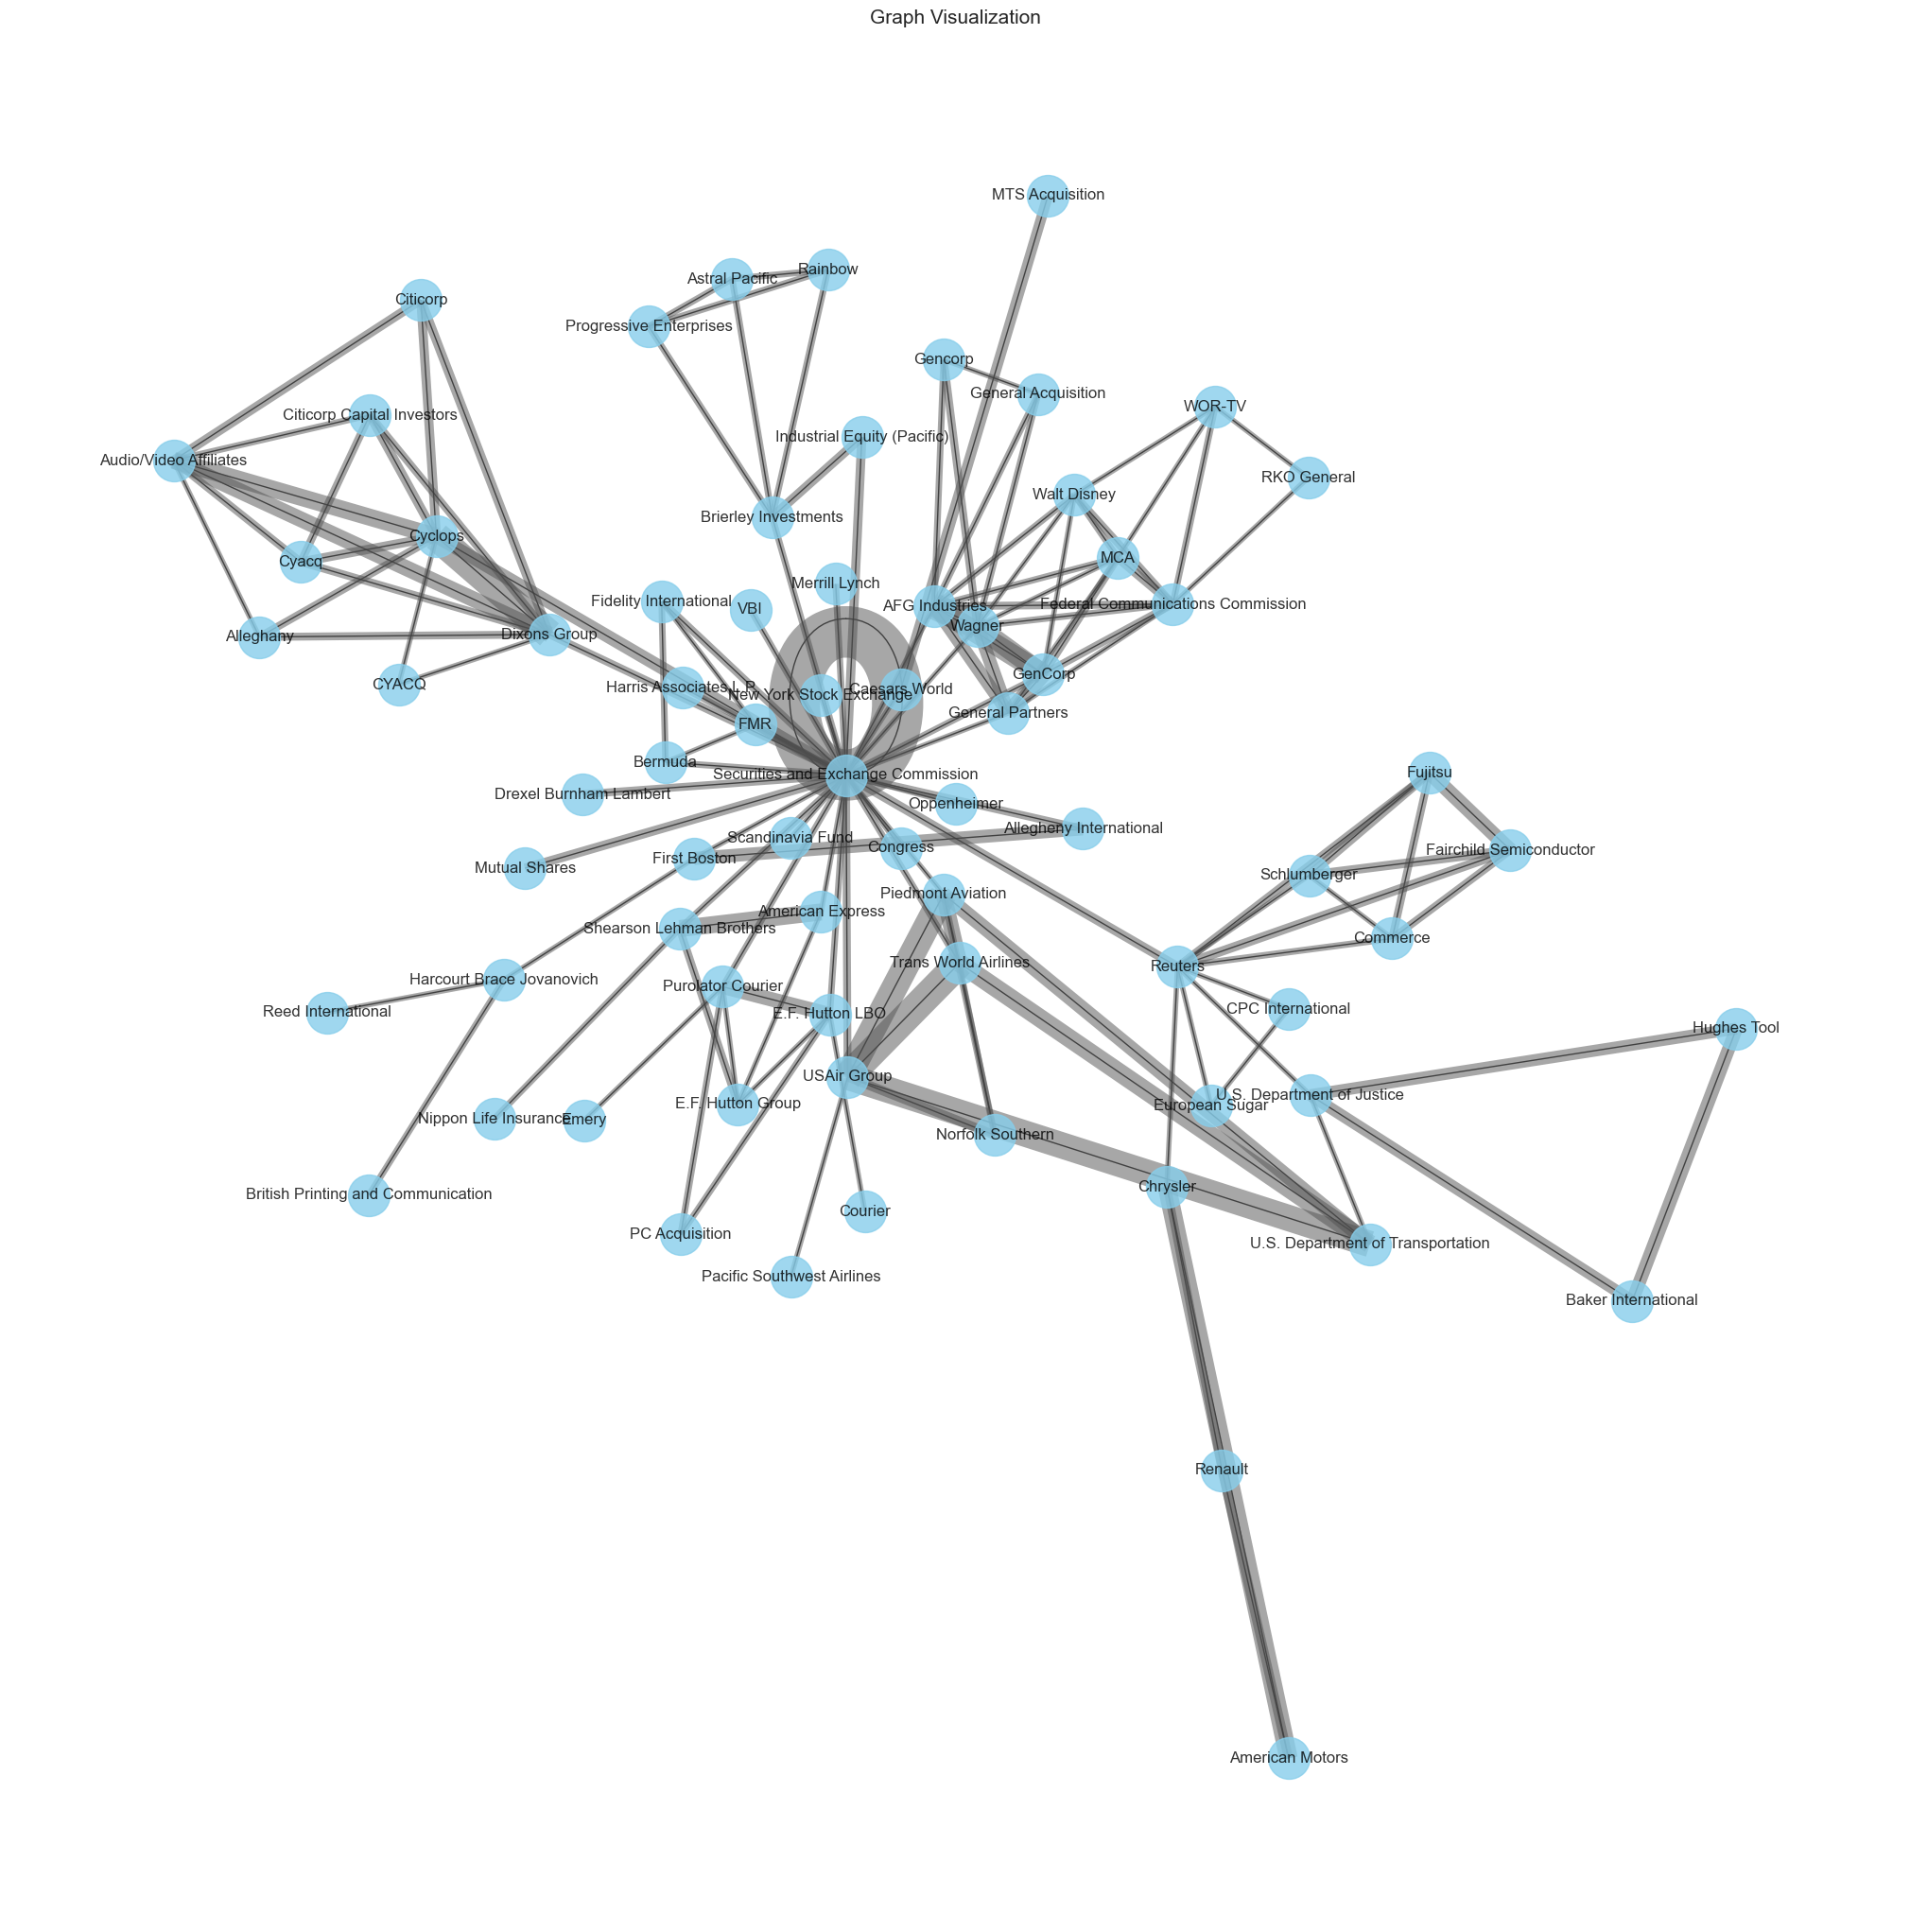

In [224]:
# identify the greatest component (connected subgraph)
# and plot only that one
giant_component = sorted(nx.connected_components(graph), key=len, reverse=True)
graph = graph.subgraph(giant_component[0])

pos = nx.kamada_kawai_layout(graph, weight='weight')
# pos = nx.fruchterman_reingold_layout(graph, weight='weight')
# pos = nx.circular_layout(graph)

_ = plt.figure(figsize=(20, 20))
nx.draw(graph, pos, 
        node_size=1000, 
        node_color='skyblue',
        alpha=0.8,
        with_labels = True)
plt.title('Graph Visualization', size=15)

for (node1,node2,data) in graph.edges(data=True):
    width = data['weight'] 
    _ = nx.draw_networkx_edges(graph,pos,
                               edgelist=[(node1, node2)],
                               width=width,
                               edge_color='#505050',
                               alpha=0.5)

plt.show()

### Blueprint: Identifying Acronyms (not in book)

It is very easy to generate a very good list of suggestions for acronyms if you search for frequent cooccurrences of acronyms. 

To find possible acronyms in the cooccurrence data frame, we look for all tuples that have an acronym (all capital letters) either as source or as target. As additional conditions, we require that the first letter in both is the same and the combination exists more than once.

In [225]:
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 
                     'init_coref', 'name_resolver', 'norm_names']) # no alias resolver

Model: core_web_sm, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14ea9bb20>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14c39bfa0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14c43de40>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x174ccac80>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x174cd2b00>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x174a41a50>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175e55900>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('name_resolver', <function name_resolver at 0x14e561040>)
('norm_names', <function norm_names at 0x14e5b1820>)


In [226]:
batch_size = 100
batches = math.ceil(len(df)/batch_size) ###

coocs = []
for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    for j, doc in enumerate(docs):
        coocs.extend([(df.index[i+j], *c) for c in extract_coocs(doc, ['ORG', 'GOV'])])

coocs = [([id], *e1, *e2) for (id, e1, e2) in coocs]

100%|█████████████████████████████████████████████| 22/22 [00:43<00:00,  1.96s/it]


In [227]:
cooc_df = pd.DataFrame.from_records(coocs, 
             columns=('article_id', 'ent1', 'type1', 'ent2', 'type2')) 
cooc_df = cooc_df.groupby(['ent1', 'ent2'])['article_id'] \
                 .agg(['count']).rename(columns={'count': 'freq'}) \
                 .reset_index().sort_values('freq', ascending=False)

acro_pattern = (cooc_df['ent1'].str.isupper() | cooc_df['ent2'].str.isupper()) & \
               (cooc_df['ent1'].str[:1] == cooc_df['ent2'].str[:1]) & \
               (cooc_df['freq'] > 1)

print(len(cooc_df[acro_pattern]))
cooc_df[acro_pattern][:10]

40


,ent1,ent2,freq
12505,SEC,Securities and Exchange Commission,39
13114,TWA,Trans World Airlines,19
2007,BP,British Petroleum,12
231,AMC,American Motors,9
1990,BIL,Brierley Investments,5
7056,FHLBB,Federal Home Loan Bank Board,5
7106,FTC,Federal Trade Commission,5
12557,SMC,San Miguel,4
9282,ITJ,International Digital Communications Planning,4
13439,WOR-TV,Walt Disney,4


For our corpus, this yields about 40 potential acronyms.

We save them to a file:

In [228]:
# export to csv
cooc_df[acro_pattern][['ent1', 'ent2']] \
  .sort_values(['ent1', 'ent2']) \
  .to_csv('possible_acronyms.txt', index=False)

This file has to be curated manually. After cleaning, we load the remaining acronyms and convert them to a dictionary:

In [229]:
# curate manually the csv
acro_df = pd.read_csv('possible_acronyms.txt')
acro_df.set_index('ent1')['ent2'].to_dict()

{'AMC': 'American Motors',
 'AMI': 'American Medical International',
 'AMR': 'American Airlines',
 'ARCO': 'Atlantic Richfield',
 'BHP': 'Bell Resources',
 'BIL': 'Brierley Investments',
 'BP': 'British Petroleum',
 'BPCC': 'British Printing and Communication',
 'BPI': 'Banco Portugues do Atlantico',
 'CYACQ': 'Cyclops',
 'DOT': 'Department of Transportation',
 'EC': 'European Community',
 'ETL': 'Equiticorp Tasman',
 'FCC': 'Federal Communications Commission',
 'FDA': 'Food and Drug Administration',
 'FHLBB': 'Federal Home Loan Bank Board',
 'FMR': 'Fidelity International',
 'FSLIC': 'Federal Savings',
 'FTC': 'Federal Trade Commission',
 'ICC': 'Interstate Commerce Commission',
 'IDC': 'International Digital Communications Planning',
 'ITJ': 'International Telecom Japan',
 'MITI': 'Ministry of International Trade and Industry',
 'PCGG': 'Presidential Commission on Good Government',
 'SEC': 'Securities and Exchange Commission',
 'SMC': 'Securities and Exchange Commission',
 'TWA': 'Tr

We took this list, and curated it to create a dictionary that maps acronyms to their long names. It is  provided in the blueprints package for this chapter and part of `alias_lookup`. Here are some example entries:

In [230]:
for acro in ['TWA', 'UCPB', 'SEC', 'DOT']:
    print(acro, ' --> ', alias_lookup[acro])

TWA  -->  ('Trans World Airlines Inc', 'ORG')
UCPB  -->  ('United Coconut Planters Bank', 'ORG')
SEC  -->  ('Securities and Exchange Commission', 'GOV')
DOT  -->  ('U.S. Department of Transportation', 'GOV')


---
<a name='12.6'></a><a id='12.6'></a>
# 12.6 Relation Extraction
<a href="#top">[back to top]</a>

<a name='12.6.1'></a><a id='12.6.1'></a>
## 12.6.1 Blueprint: Extracting Relations Using Phrase Matching
<a href="#top">[back to top]</a>

In [231]:
import en_core_web_lg
nlp = en_core_web_lg.load()

# need to re-create the entity ruler after reloading nlp
# because new entity type 'GOV' needs to be added to nlp.vocab
entity_ruler = EntityRuler(nlp, patterns=patterns, overwrite_ents=True)

In [232]:
# Use the large model, otherwise the examples look different.
# To make it work on Colab, we need to import the model directly.
# usually you would use nlp = spacy.load('en_core_web_lg') 
# import spacy
# from spacy.lang.en.examples import sentences 

# nlp = spacy.load('en_core_web_lg')

# need to re-create the entity ruler after reloading nlp
# because new entity type 'GOV' needs to be added to nlp.vocab
# entity_ruler = EntityRuler(nlp, patterns=patterns, overwrite_ents=True)

# recreate pipeline
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 
                     'init_coref', 'alias_resolver', 'name_resolver', 
                     'neural_coref', 'anaphor_coref', 'norm_names'])

Model: core_web_lg, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14f2bb5e0>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14f2bbca0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14f64a430>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x170504580>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x1742fa8c0>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x14f64a190>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x175df1240>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('alias_resolver', <function alias_resolver at 0x14e541940>)
('name_resolver', <function name_resolver at 0x14e561040>)
('neural_coref', <function neural_coref at 0x14e5838b0>)
('anaphor_coref', <function anaphor_coref at 0x14c47f9d0>)
('norm_names', <functio

In [233]:
text = """Fujitsu plans to acquire 80% of Fairchild Corp, an industrial unit
of Schlumberger."""
text = re.sub('\s+', ' ', text).strip() ###

In [234]:
doc = nlp(text)

displacy.render(doc, style='ent', jupyter=True)

In [235]:
matcher = Matcher(nlp.vocab)

acq_synonyms = ['acquire', 'buy', 'purchase']
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'OP': '*'},
           {'POS': 'VERB', 'LEMMA': {'IN': acq_synonyms}},
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'OP': '*'},
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('acquires', [pattern])

In [236]:
subs_synonyms = ['subsidiary', 'unit']
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 
            'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'LOWER': {'IN': subs_synonyms}}, {'TEXT': 'of'},
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 
            'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('subsidiary-of', [pattern])

In [237]:
def extract_rel_match(doc, matcher):
    for sent in doc.sents:
        for match_id, start, end in matcher(sent):
            span = sent[start:end]  # matched span
            pred = nlp.vocab.strings[match_id] # rule name
            subj, obj = span[0], span[-1]
            if pred.startswith('rev-'): # reversed relation
                subj, obj = obj, subj
                pred = pred[4:]
            yield ((subj._.ref_n, subj._.ref_t), pred, 
                   (obj._.ref_n, obj._.ref_t))

In [238]:
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'LOWER': {'IN': subs_synonyms}}, # predicate
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('rev-subsidiary-of', [pattern])

In [239]:
text = """Fujitsu plans to acquire 80% of Fairchild Corp, an industrial unit 
of Schlumberger. The Schlumberger unit Fairchild Corp received an offer."""
text = re.sub('\s+', ' ', text) ###
doc = nlp(text)
print(*extract_rel_match(doc, matcher), sep='\n')

(('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
(('Fairchild', 'ORG'), 'subsidiary-of', ('Schlumberger', 'ORG'))
(('Fairchild', 'ORG'), 'subsidiary-of', ('Schlumberger', 'ORG'))


In [240]:
text = "Fairchild Corp was acquired by Fujitsu."
print(*extract_rel_match(nlp(text), matcher), sep='\n')

(('Fairchild', 'ORG'), 'acquires', ('Fujitsu', 'ORG'))


In [241]:
text = "Fujitsu, a competitor of NEC, acquired Fairchild Corp."
print(*extract_rel_match(nlp(text), matcher), sep='\n')

(('NEC', 'ORG'), 'acquires', ('Fairchild', 'ORG'))


In [242]:
if matcher.has_key("acquires"): 
    matcher.remove("acquires")

<a name='12.6.2'></a><a id='12.6.2'></a>
## 12.6.2 Blueprint: Extracting Relations Using Dependency Trees
<a href="#top">[back to top]</a>

In [243]:
nlp.component_names

['tok2vec',
 'tagger',
 'parser',
 'senter',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler',
 'norm_entities',
 'merge_entities',
 'init_coref',
 'alias_resolver',
 'name_resolver',
 'neural_coref',
 'anaphor_coref',
 'norm_names']

In [244]:
# recreate pipeline
reset_pipeline(nlp, ['entity_ruler', 'norm_entities', 'merge_entities', 
                     'init_coref', 'alias_resolver', 'name_resolver',
                     'neural_coref', 'anaphor_coref', 'norm_names'])

Model: core_web_lg, Language: en
('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x14f2bb5e0>)
('tagger', <spacy.pipeline.tagger.Tagger object at 0x14f2bbca0>)
('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x14f64a430>)
('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x170504580>)
('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x1742fa8c0>)
('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x14f64a190>)
('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x16db5d8c0>)
('norm_entities', <function norm_entities at 0x14e4fb790>)
('merge_entities', <function merge_entities at 0x14b04b1f0>)
('init_coref', <function init_coref at 0x14e53c700>)
('alias_resolver', <function alias_resolver at 0x14e541940>)
('name_resolver', <function name_resolver at 0x14e561040>)
('neural_coref', <function neural_coref at 0x14e5838b0>)
('anaphor_coref', <function anaphor_coref at 0x14c47f9d0>)
('norm_names', <functio

In [245]:
text = "Fujitsu, a competitor of NEC, acquired Fairchild Corp."
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, 
                options={'compact': False, 'distance': 100})

In [246]:
text = "Fairchild Corp was acquired by Fujitsu."
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, options={'compact': False, 'distance': 100})

In [247]:
# Here is the longer part of the code, that was skipped in the book.

# Actually we search for the shortest path between the
# subject running through our predicate (verb) to the object.
# subject and object are organizations in our examples.

# Here are the three helper functions omitted in the book:
# - bfs: breadth first searching the closest subject/object 
# - is_passive: checks if noun or verb is in passive form
# - find_subj: searches left part of tree for subject
# - find_obj: searches right part of tree for object

from collections import deque

def bfs(root, ent_type, deps, first_dep_only=False):
    """Return first child of root (included) that matches
    ent_type and dependency list by breadth first search.
    Search stops after first dependency match if first_dep_only
    (used for subject search - do not "jump" over subjects)"""
    to_visit = deque([root]) # queue for bfs

    while len(to_visit) > 0:
        child = to_visit.popleft()
        # print("child", child, child.dep_)
        if child.dep_ in deps:
            if child._.ref_t == ent_type:
                return child
            elif first_dep_only: # first match (subjects)
                return None
        elif child.dep_ == 'compound' and \
             child.head.dep_ in deps and \
             child._.ref_t == ent_type: # check if contained in compound
            return child
        to_visit.extend(list(child.children))
    return None

def is_passive(token):
    if token.dep_.endswith('pass'): # noun
        return True
    for left in token.lefts: # verb
        if left.dep_ == 'auxpass':
            return True
    return False

def find_subj(pred, ent_type, passive):
    """Find closest subject in predicates left subtree or
    predicates parent's left subtree (recursive).
    Has a filter on organizations."""
    for left in pred.lefts:
        if passive: # if pred is passive, search for passive subject
            subj = bfs(left, ent_type, ['nsubjpass', 'nsubj:pass'], True)
        else:
            subj = bfs(left, ent_type, ['nsubj'], True)
        if subj is not None: # found it!
            return subj
    if pred.head != pred and not is_passive(pred): 
        return find_subj(pred.head, ent_type, passive) # climb up left subtree
    else:
        return None

def find_obj(pred, ent_type, excl_prepos):
    """Find closest object in predicates right subtree.
    Skip prepositional objects if the preposition is in exclude list.
    Has a filter on organizations."""
    for right in pred.rights:
        obj = bfs(right, ent_type, ['dobj', 'pobj', 'iobj', 'obj', 'obl'])
        if obj is not None:
            if obj.dep_ == 'pobj' and obj.head.lemma_.lower() in excl_prepos: # check preposition
                continue
            return obj
    return None

In [248]:
def extract_rel_dep(doc, pred_name, pred_synonyms, excl_prepos=[]):
    for token in doc:
        if token.pos_ == 'VERB' and token.lemma_ in pred_synonyms:
            pred = token
            passive = is_passive(pred)
            subj = find_subj(pred, 'ORG', passive)
            if subj is not None:
                obj = find_obj(pred, 'ORG', excl_prepos)
                if obj is not None:
                    if passive: # switch roles
                        obj, subj = subj, obj
                    yield ((subj._.ref_n, subj._.ref_t), pred_name, 
                           (obj._.ref_n, obj._.ref_t))

In [249]:
text = """Fujitsu said that Schlumberger Ltd has arranged 
to sell its stake in Fairchild Inc."""
doc = nlp(text)
print(*extract_rel_dep(doc, 'sells', ['sell']), sep='\n')

(('Schlumberger', 'ORG'), 'sells', ('Fairchild', 'ORG'))


In [250]:
text = "Schlumberger Ltd has arranged to sell to Fujitsu its stake in Fairchild Inc."
doc = nlp(text)
print(*extract_rel_dep(doc, 'sells', ['sell']), sep='\n')
displacy.render(doc, style='dep', jupyter=True, options={'compact': False, 'distance': 80})

(('Schlumberger', 'ORG'), 'sells', ('Fujitsu', 'ORG'))


In [251]:
print("A:", *extract_rel_dep(doc, 'sells', ['sell']))
print("B:", *extract_rel_dep(doc, 'sells', ['sell'], ['to', 'from']))

A: (('Schlumberger', 'ORG'), 'sells', ('Fujitsu', 'ORG'))
B:


In [252]:
texts = [ 
     "Fairchild Corp was bought by Fujitsu.", # 1
     "Fujitsu, a competitor of NEC Co, acquired Fairchild Inc.", # 2
     "Fujitsu is expanding." + 
     "The company made an offer to acquire 80% of Fairchild Inc.", # 3
     "Fujitsu plans to acquire 80% of Fairchild Corp.", # 4
     "Fujitsu plans not to acquire Fairchild Corp.", # 5
     "The competition forced Fujitsu to aquire Fairchild Corp." # 6
]

acq_synonyms = ['acquire', 'buy', 'purchase']
for i, text in enumerate(texts):
    doc = nlp(text)
    rels = extract_rel_dep(doc, 'acquires', acq_synonyms, ['to', 'from'])
    print(f'{i+1}:', *rels)

1: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
2: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
3:
4: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
5: (('Fujitsu', 'ORG'), 'acquires', ('Fairchild', 'ORG'))
6:


---
<a name='12.7'></a><a id='12.7'></a>
# 12.7 Creating the Knowledge Graph
<a href="#top">[back to top]</a>

**On Colab**: Choose "Runtime"&rarr;"Change Runtime Type"&rarr;"GPU" to benefit from the GPUs.

In [253]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [254]:
nlp = spacy.load('en_core_web_lg')

print(nlp.pipe_names)
HR()

# Need to re-create the entity ruler after reloading nlp
# because new entity type 'GOV' needs to be added to nlp.vocab
entity_ruler = EntityRuler(nlp, patterns=patterns, overwrite_ents=True)

pipes = ['entity_ruler', 'norm_entities', 'merge_entities',
         'init_coref', 'alias_resolver', 'name_resolver', 
         'neural_coref', 'anaphor_coref', 'norm_names']

for pipe in pipes:
    nlp.add_pipe(pipe)
    
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
----------------------------------------
['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'entity_ruler', 'norm_entities', 'merge_entities', 'init_coref', 'alias_resolver', 'name_resolver', 'neural_coref', 'anaphor_coref', 'norm_names']


In [255]:
# recreate matcher - same definition as above for these rules
matcher = Matcher(nlp.vocab)

subs_synonyms = ['subsidiary', 'unit']
pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'LOWER': {'IN': subs_synonyms}}, # predicate
           {'TEXT': 'of'},
           {'_': {'ref_t': {'NOT_IN': ['ORG']}}, 'POS': {'NOT_IN': ['VERB']}, 'OP': '*'},
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('subsidiary-of', [pattern])

pattern = [{'_': {'ref_t': 'ORG'}}, # subject
           {'POS': 'PART', 'OP': '?'},
           {'LOWER': {'IN': subs_synonyms}}, # predicate
           {'_': {'ref_t': 'ORG'}}] # object
matcher.add('rev-subsidiary-of', [pattern])

In [256]:
ceo_synonyms = ['chairman', 'president', 'director', 'ceo', 'executive']
pattern = [{'ENT_TYPE': 'PERSON'},
           {'ENT_TYPE': {'NOT_IN': ['ORG', 'PERSON']}, 'OP': '*'}, 
           {'LOWER': {'IN': ceo_synonyms}}, {'TEXT': 'of'},
           {'ENT_TYPE': {'NOT_IN': ['ORG', 'PERSON']}, 'OP': '*'}, 
           {'ENT_TYPE': 'ORG'}] 
matcher.add('executive-of', [pattern])

pattern = [{'ENT_TYPE': 'ORG'}, 
           {'LOWER': {'IN': ceo_synonyms}},
           {'ENT_TYPE': 'PERSON'}] 
matcher.add('rev-executive-of', [pattern])

In [257]:
def extract_rels(doc):
    yield from extract_rel_match(doc, matcher)
    yield from extract_rel_dep(doc, 'acquires', acq_synonyms, ['to', 'from'])
    yield from extract_rel_dep(doc, 'sells', ['sell'], ['to', 'from'])

## Testing Relationship Extraction (not in book)

In [258]:
text = """Allied-Signal Inc and Schlumberger Ltd jointly announced 
that Schlumberger had acquired Allied-Signal's unit Neptune International. 
"""

#text = df.text.loc[19975]

text = re.sub(r'\s+', ' ', text).strip()
print(*textwrap.wrap(text, 100), sep='\n')
print()

doc = nlp(text, disable='entity_ruler')
#displacy.render(doc, style='ent')

print(*extract_rels(doc), sep='\n')
displacy.render(doc, style='dep', jupyter=True, options={'compact': False, 'distance': 100})

Allied-Signal Inc and Schlumberger Ltd jointly announced that Schlumberger had acquired Allied-
Signal's unit Neptune International.

(('Neptune International', 'ORG'), 'subsidiary-of', ('Allied-Signal', 'ORG'))


## Extraction of Entities and Relations and Creation of Gephi-File (not in book)

Batch-processing for entity extraction with subsequent relation extraction. Takes about 5 minutes,  80% of runtime for NeuralCoref.

In [259]:
%%time

batch_size = 20
batches = ceil(len(df) / batch_size) ###

rels = []
for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    for j, doc in enumerate(docs):
        rels.extend([(df.index[i+j], *r) for r in extract_rels(doc)])

100%|███████████████████████████████████████████| 108/108 [00:50<00:00,  2.16it/s]

CPU times: user 43.7 s, sys: 5.34 s, total: 49 s
Wall time: 50.1 s


Creation of the relation data frame including final curation:

In [260]:
# unpack subject and object 
rels = [(a_id, *subj, pred, *obj) for (a_id, subj, pred, obj) in rels]

# create data frame
rel_df = pd.DataFrame.from_records(rels, columns=('article_id', 'subj', 'subj_type', 'pred', 'obj', 'obj_type'))

# false positives: subject cannot be object
rel_df = rel_df.query('subj != obj')

# filter entities that were not correctly detected
# tokenizer produces "-owned XYZ company"
rel_df = rel_df[~rel_df['subj'].str.startswith('-own')]
rel_df = rel_df[~rel_df['obj'].str.startswith('-own')]

# drop duplicate relations (within an article)
rel_df = rel_df.drop_duplicates()

# aggregate to produce one record per relation
rel_df['article_id'] = rel_df['article_id'].progress_map(lambda a: [a])
rel_df = rel_df.groupby(['subj', 'subj_type', 'pred', 'obj', 'obj_type'])['article_id'] \
                 .agg(['count', 'sum']) \
                 .rename(columns={'count': 'freq', 'sum': 'articles'}) \
                 .reset_index().sort_values('freq', ascending=False)

rel_df['articles'] = rel_df['articles'].progress_map(lambda lst: ','.join(list(set([str(a) for a in lst]))))
rel_df.head(10)

progress-bar: 100%|██████████████████████████| 911/911 [00:00<00:00, 94927.23it/s]


,subj,subj_type,pred,obj,obj_type,freq,articles
840,Trans World Airlines,ORG,acquires,USAir Group,ORG,7,"3013,1862,2950,5671,5750,7650,1836"
160,Chrysler,ORG,acquires,American Motors,ORG,5,"3795,3056,3198,7796,3100"
238,Dart Group,ORG,acquires,Supermarkets General,ORG,5,"3912,3313,5352,3242,9230"
785,Shearson Lehman Brothers,ORG,subsidiary-of,American Express,ORG,4,"6944,2768,2543,7024"
763,Samuel Heyman,PERSON,executive-of,GAF,ORG,4,"15063,16513,11661,11504"
255,Dixons Group,ORG,acquires,Cyclops,ORG,3,"9526,16925,10883"
49,American Express,ORG,sells,Shearson Lehman Brothers,ORG,3,"6707,7391,110"
1,A. William Reynolds,PERSON,executive-of,GenCorp,ORG,3,"11492,9638,6665"
581,Minories Finance Limited,ORG,subsidiary-of,Bank of England,ORG,3,"12053,12339,12068"
537,MTS Acquisition,ORG,acquires,Caesars World,ORG,3,"8496,3320,3023"


In [261]:
# some statitics
rel_df['pred'].value_counts()

acquires         526
executive-of     154
sells            138
subsidiary-of     93
Name: pred, dtype: int64

In [262]:
# try searching for a specific entity
search = "Trans World"
rel_df[(rel_df.subj.str.lower().str.contains(search.lower()) | 
        rel_df.obj.str.lower().str.contains(search.lower()))]

,subj,subj_type,pred,obj,obj_type,freq,articles
840,Trans World Airlines,ORG,acquires,USAir Group,ORG,7,"3013,1862,2950,5671,5750,7650,1836"
143,Carl Icahn,PERSON,executive-of,Trans World Airlines,ORG,3,"3095,2799,1836"
841,Trans World Airlines,ORG,sells,USAir Group,ORG,1,9487


In [263]:
# in fact, TWA acquires and sells parts of USAir according to the messages
# look at a specific article
text = df['text'][9487]
print(*textwrap.wrap(text, 80), sep='\n')

Trans World Airlines Inc sold four million shares it held in USAir Group Inc,
Wall Street sources said. The sources said the buyers are believed to be a group
of institutions. Bear Stearns handled the trade. It crossed the four million
shares at 45, off 1/8. Bear Stearns would not comment on buyers or sellers.
USAir and TWA had no immediate comment. USAir later said it did not buy the
stock. A company spokesman would not comment further. TWA earlier this month
reported holding slightly more than four million shares, or about 15 % of USAir.
It had also proposed a takeover of USAir, which at the time was negotiating its
proposed merger with Piedmont Aviation Inc. On March 16, TWA withdrew its bid,
saying it did not intend to seek control of USAir Group or to acquire more of
its stock at the time. TWA also said in the filing with the Securities and
Exchange Commission that its chairman, Carl Icahn is the target of an SEC probe
of alleged violations of securities laws. In its filings with 

To create the NetworkX graph be careful: We need a `MultiDiGraph` here, a directed graph allowing multiple edges between two nodes!

In [264]:
graph = MultiDiGraph()
for i, row in rel_df.iterrows():
    graph.add_node(row['subj'], Type=row['subj_type'])
    graph.add_node(row['obj'], Type=row['obj_type'])
    _ = graph.add_edge(row['subj'], row['obj'], 
                   Articles=row['articles'], Rel=row['pred'])

In [273]:
nx.readwrite.write_gexf(
    graph, 
    'knowledge_graph.gexf', 
    encoding='utf-8', 
    prettyprint=True, 
    version='1.2draft'
)

Choose merge strategy "last" when you load the data into Gephi, as relations with highest counts come last in the gexf file.

If you are interested, install *Gephi* and open `knowledge_graph.gexf` from Gephi.

In [271]:
print("Done")

Done
